# Выбор локации для скважины

В добывающей компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину. Компанией предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. 

**Цель исследования:** Построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль.

**Ход исследования:** Данные загружаются из датасетов: ```geo_data_0.csv```, ```geo_data_1.csv```, ```geo_data_2.csv```. Поскольку качество данных неизвестно, сначала необходимо их изучить. В случае обнаружения ошибок и их влияния на исследование на этапе предобработки данных будет рассмотрены варианты исправления ошибок без искажения конечных результатов. В ходе исследовательского и корреляционного анализа будут выявленные наиболее важные особенности данных. В соответствии с требованиями заказчика будет применена модель линейной регрессии в связи с ее предсказуемостью для определения  объёма запасов в новых скважинах. Затем будут выбраны скважены с самыми высокими оценками значений, чтобы определить регион с максимальной суммарной прибылью отобранных скважин. Возможная прибыли и риски будут проанализированы техникой Bootstrap.


**Описание данных:**
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

## Загрузка и подготовка данных

### Загрузка и предобработка данных

In [1]:
!pip -q install phik
import phik 
import math

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
try:
    geo_0 = pd.read_csv('/datasets/geo_data_0.csv')
    geo_1 = pd.read_csv('/datasets/geo_data_1.csv')
    geo_2 = pd.read_csv('/datasets/geo_data_2.csv')
    
except:
    geo_0 = pd.read_csv('https://code.s3.yandex.net//datasets/geo_data_0.csv')
    geo_1 = pd.read_csv('https://code.s3.yandex.net//datasets/geo_data_1.csv')
    geo_2 = pd.read_csv('https://code.s3.yandex.net//datasets/geo_data_2.csv')

In [3]:
#создадим функцию для вывода основной информации по датасетам
def general_info(df):
    display(df.head(10))
    display(df.info())
    display(df.nunique())

In [4]:
general_info(geo_0)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

id          99990
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

In [5]:
general_info(geo_1)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

id          99996
f0         100000
f1         100000
f2         100000
product        12
dtype: int64

In [6]:
general_info(geo_2)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

id          99996
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

In [7]:
print(geo_0.duplicated().sum())
print(geo_1.duplicated().sum())
geo_2.duplicated().sum()

0
0


np.int64(0)

In [8]:
geo_0 = geo_0.drop_duplicates(subset=['id'])
geo_1 = geo_1.drop_duplicates(subset=['id'])
geo_2 = geo_2.drop_duplicates(subset=['id'])

**Вывод:**
- Пропусков в данных нет, явных дубликатов тоже, однако уникальных значений id меньше, чем объектов в датасете, что означает, что признаки некоторых скважен расчитывались несколько раз, их мы удалили из датасета, поскольку их число незначительно относительно всего набора данных.
- Замечено необычное число уникальных значений целевого признака во втором датасете - всего 12 штук.
- Входящие признаки и целевой вещественного типа данных, не требуют преобразования. 

Далее проведем исследовательский и корреляционный анализ. 

### Исследовательский анализ

#### Целевой признак

In [9]:
geo_0['product'].describe()

count    99990.000000
mean        92.499684
std         44.288304
min          0.000000
25%         56.497069
50%         91.847928
75%        128.563699
max        185.364347
Name: product, dtype: float64

In [10]:
geo_1['product'].describe()

count    99996.000000
mean        68.823916
std         45.944663
min          0.000000
25%         26.953261
50%         57.085625
75%        107.813044
max        137.945408
Name: product, dtype: float64

In [11]:
geo_2['product'].describe()

count    99996.000000
mean        94.998342
std         44.749573
min          0.000000
25%         59.450028
50%         94.925026
75%        130.586815
max        190.029838
Name: product, dtype: float64

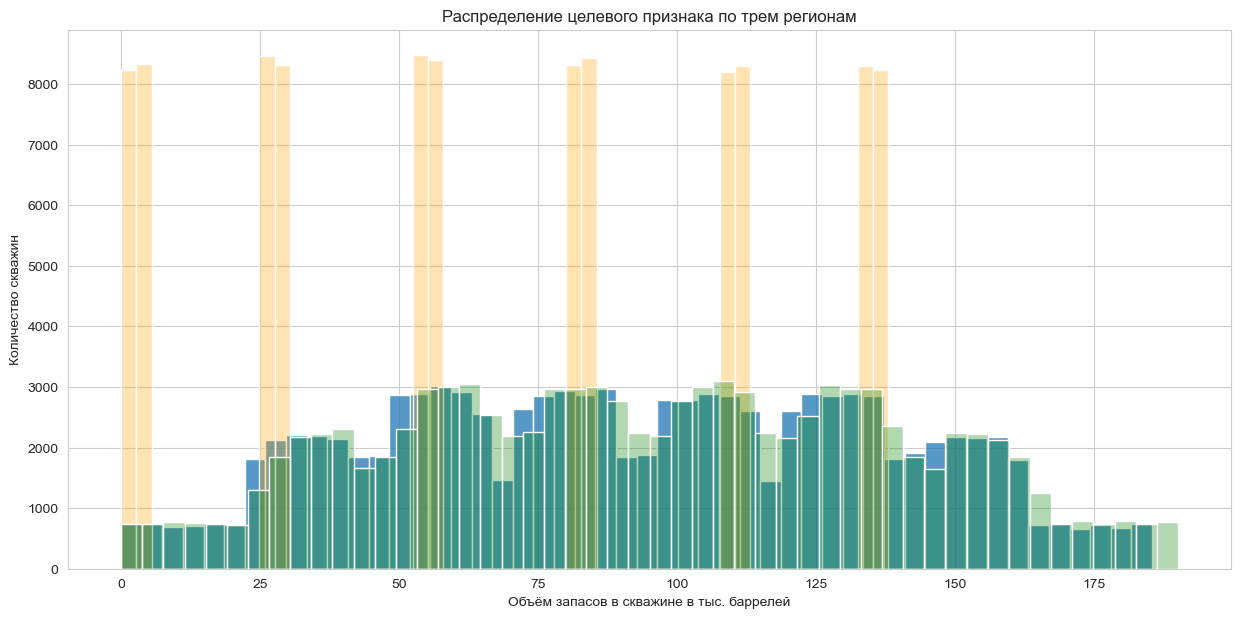

In [12]:
sns.set_style("whitegrid")
plt.figure(figsize=(15,7))
b = sns.histplot(data=geo_0, bins=50,  x = 'product')
sns.histplot(data=geo_1, bins=50, x = 'product', color='orange', alpha=0.3)
sns.histplot(data=geo_2, bins=50, x = 'product', color='green', alpha=0.3)
plt.title('Распределение целевого признака по трем регионам')
b.set_xlabel('Объём запасов в скважине в тыс. баррелей')
b.set_ylabel('Количество скважин');

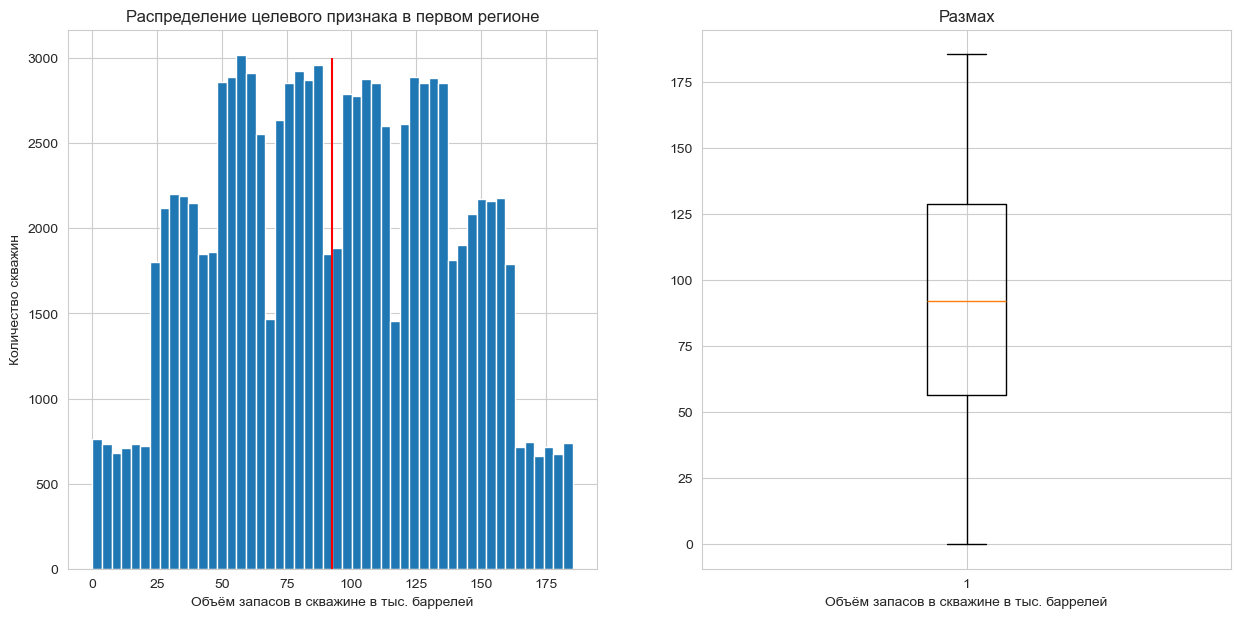

In [13]:
figure, ax =plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
ax[0].hist(geo_0['product'], bins=50)
ax[0].vlines(geo_0['product'].mean(), ymin=0, ymax=3000, color='red')
ax[0].set_title('Распределение целевого признака в первом регионе')
ax[0].set_xlabel('Объём запасов в скважине в тыс. баррелей')
ax[0].set_ylabel('Количество скважин')


ax[1].boxplot(geo_0['product'])
ax[1].set_title('Размах')
ax[1].set_xlabel('Объём запасов в скважине в тыс. баррелей')
plt.show()

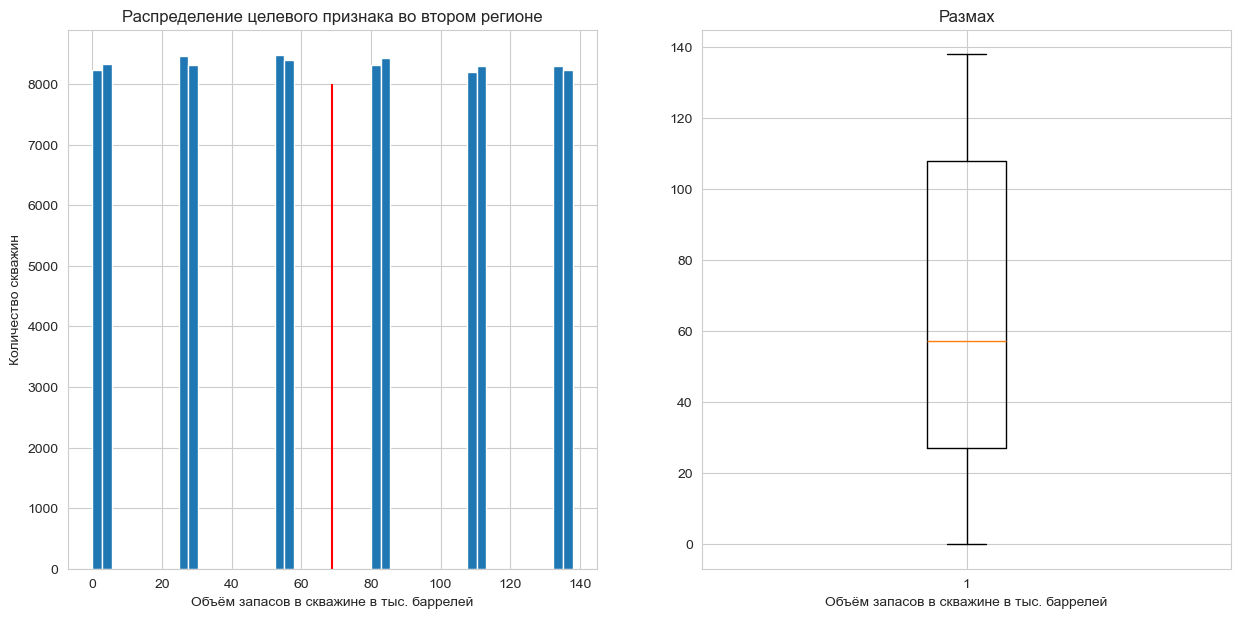

In [14]:
figure, ax =plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
ax[0].hist(geo_1['product'], bins=50)
ax[0].vlines(geo_1['product'].mean(), ymin=0, ymax=8000, color='red')
ax[0].set_title('Распределение целевого признака во втором регионе')
ax[0].set_xlabel('Объём запасов в скважине в тыс. баррелей')
ax[0].set_ylabel('Количество скважин')


ax[1].boxplot(geo_1['product'])
ax[1].set_title('Размах')
ax[1].set_xlabel('Объём запасов в скважине в тыс. баррелей')
plt.show()

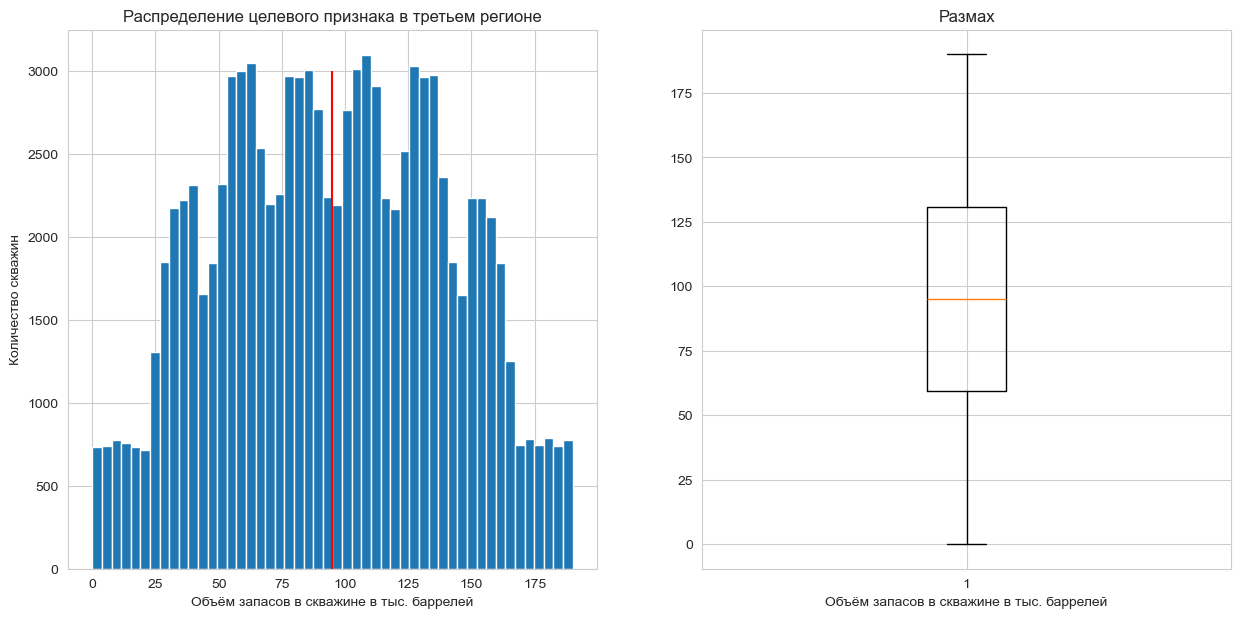

In [15]:
figure, ax =plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
ax[0].hist(geo_2['product'], bins=50)
ax[0].vlines(geo_2['product'].mean(), ymin=0, ymax=3000, color='red')
ax[0].set_title('Распределение целевого признака в третьем регионе')
ax[0].set_xlabel('Объём запасов в скважине в тыс. баррелей')
ax[0].set_ylabel('Количество скважин')


ax[1].boxplot(geo_2['product'])
ax[1].set_title('Размах')
ax[1].set_xlabel('Объём запасов в скважине в тыс. баррелей')
plt.show()

- Данные распределены симметрично относительно среднего значения в первом и третьем регионе, значения нормально распределены в диапазоне от 0 до 185-190 тысяч баррелей со средним 90-95.
- Отличается распределение целевого признака второго региона. Данные распределены категориально по 12 уникальным значениям. Максимальное и среднее значение объемов запасов меньше, чем в остальных регионах. Они составляют примерно 140 и 70 тыс. баррелей. 

#### Признак f0

In [16]:
geo_0.f0.describe()

count    99990.000000
mean         0.500454
std          0.871844
min         -1.408605
25%         -0.072572
50%          0.502405
75%          1.073626
max          2.362331
Name: f0, dtype: float64

In [17]:
geo_1.f0.describe()

count    99996.000000
mean         1.141209
std          8.965815
min        -31.609576
25%         -6.298551
50%          1.153055
75%          8.620964
max         29.421755
Name: f0, dtype: float64

In [18]:
geo_2.f0.describe()

count    99996.000000
mean         0.002002
std          1.732052
min         -8.760004
25%         -1.162328
50%          0.009424
75%          1.158477
max          7.238262
Name: f0, dtype: float64

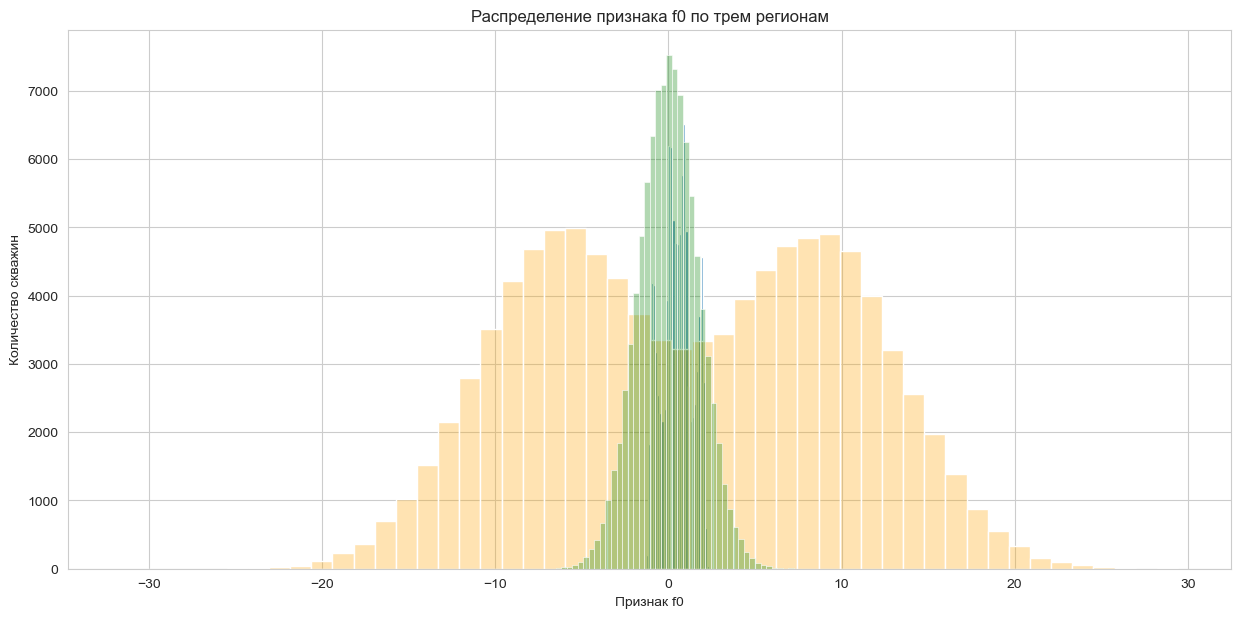

In [19]:
plt.figure(figsize=(15,7))
b = sns.histplot(data=geo_0, bins=30,  x = 'f0')
sns.histplot(data=geo_1, bins=50, x = 'f0', color='orange', alpha=0.3)
sns.histplot(data=geo_2, bins=50, x = 'f0', color='green', alpha=0.3)
plt.title('Распределение признака f0 по трем регионам')
b.set_xlabel('Признак f0')
b.set_ylabel('Количество скважин');

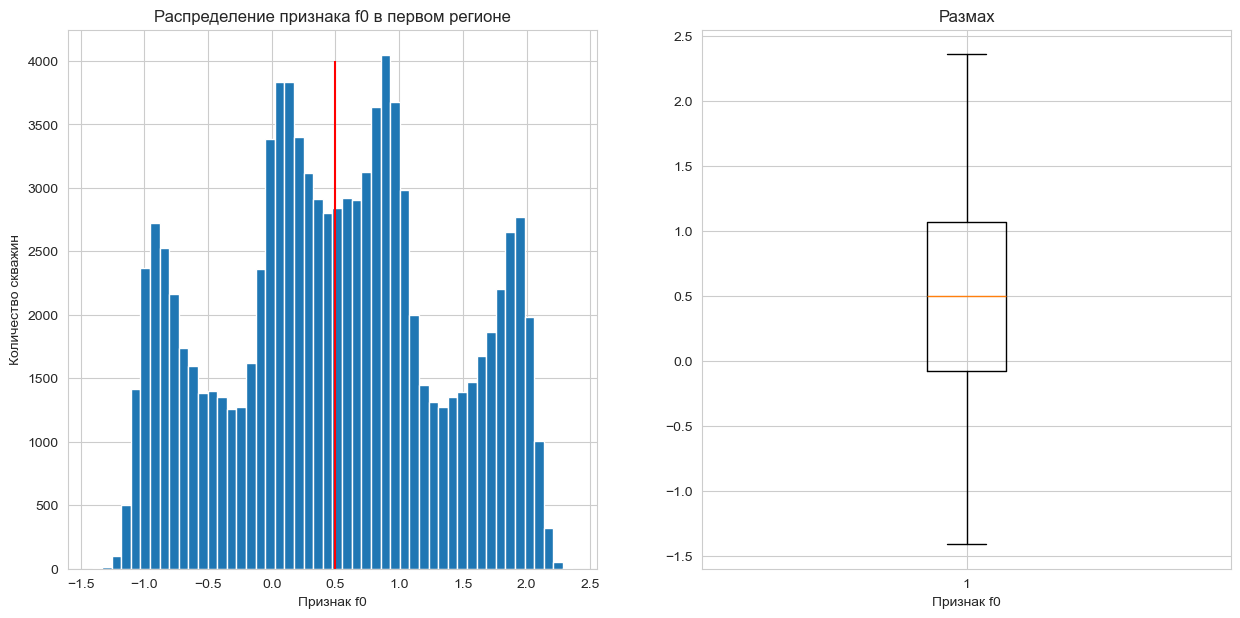

In [20]:
figure, ax =plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
ax[0].hist(geo_0['f0'], bins=50)
ax[0].vlines(geo_0['f0'].mean(), ymin=0, ymax=4000, color='red')
ax[0].set_title('Распределение признака f0 в первом регионе')
ax[0].set_xlabel('Признак f0')
ax[0].set_ylabel('Количество скважин')


ax[1].boxplot(geo_0['f0'])
ax[1].set_title('Размах')
ax[1].set_xlabel('Признак f0')
plt.show()

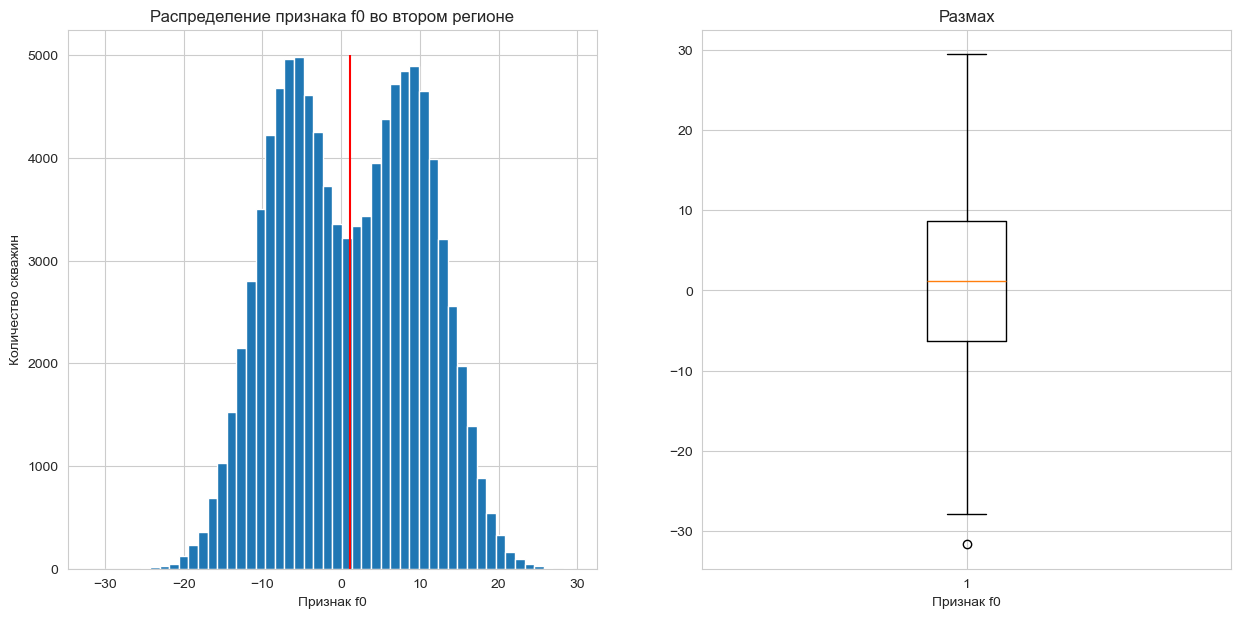

In [21]:
figure, ax =plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
ax[0].hist(geo_1['f0'], bins=50)
ax[0].vlines(geo_1['f0'].mean(), ymin=0, ymax=5000, color='red')
ax[0].set_title('Распределение признака f0 во втором регионе')
ax[0].set_xlabel('Признак f0')
ax[0].set_ylabel('Количество скважин')


ax[1].boxplot(geo_1['f0'])
ax[1].set_title('Размах')
ax[1].set_xlabel('Признак f0')
plt.show()

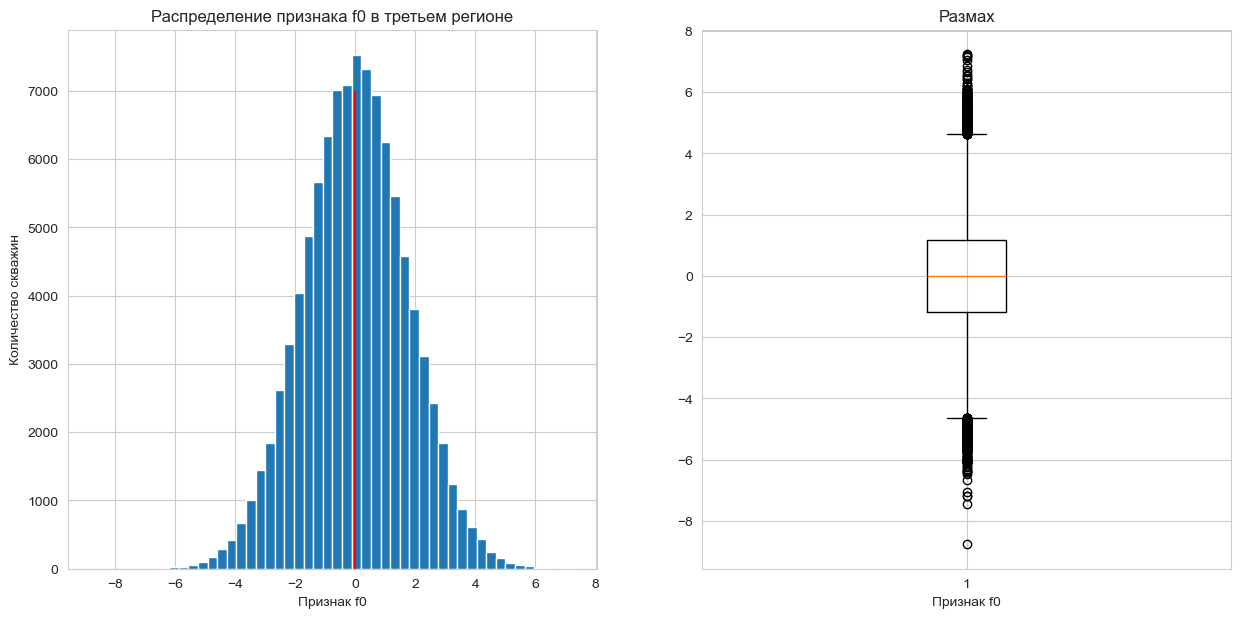

In [22]:
figure, ax =plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
ax[0].hist(geo_2['f0'], bins=50)
ax[0].vlines(geo_2['f0'].mean(), ymin=0, ymax=7000, color='red')
ax[0].set_title('Распределение признака f0 в третьем регионе')
ax[0].set_xlabel('Признак f0')
ax[0].set_ylabel('Количество скважин')


ax[1].boxplot(geo_2['f0'])
ax[1].set_title('Размах')
ax[1].set_xlabel('Признак f0')
plt.show()

#### Призак f1

In [23]:
display(geo_0.f1.describe())
display(geo_1.f1.describe())
geo_2.f1.describe()

count    99990.000000
mean         0.250141
std          0.504430
min         -0.848218
25%         -0.200877
50%          0.250252
75%          0.700640
max          1.343769
Name: f1, dtype: float64

count    99996.000000
mean        -4.796608
std          5.119906
min        -26.358598
25%         -8.267985
50%         -4.813172
75%         -1.332816
max         18.734063
Name: f1, dtype: float64

count    99996.000000
mean        -0.002159
std          1.730397
min         -7.084020
25%         -1.174841
50%         -0.009661
75%          1.163523
max          7.844801
Name: f1, dtype: float64

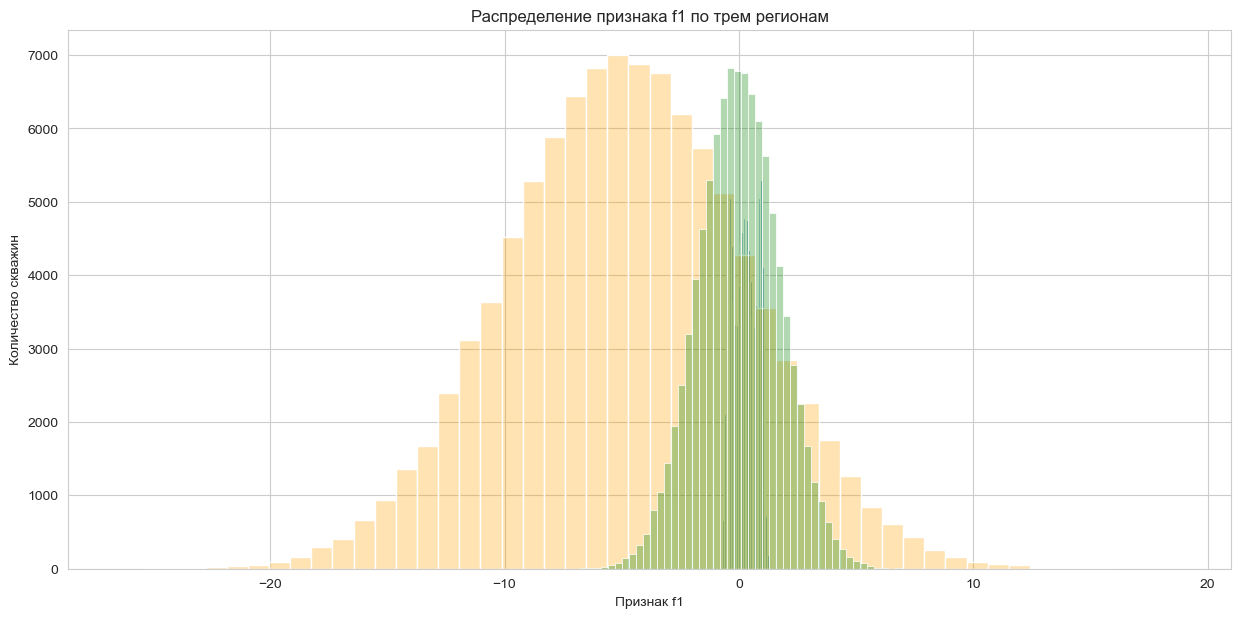

In [24]:
plt.figure(figsize=(15,7))
b = sns.histplot(data=geo_0, bins=30,  x ='f1')
sns.histplot(data=geo_1, bins=50, x = 'f1', color='orange', alpha=0.3)
sns.histplot(data=geo_2, bins=50, x = 'f1', color='green', alpha=0.3)
plt.title('Распределение признака f1 по трем регионам')
b.set_xlabel('Признак f1')
b.set_ylabel('Количество скважин');

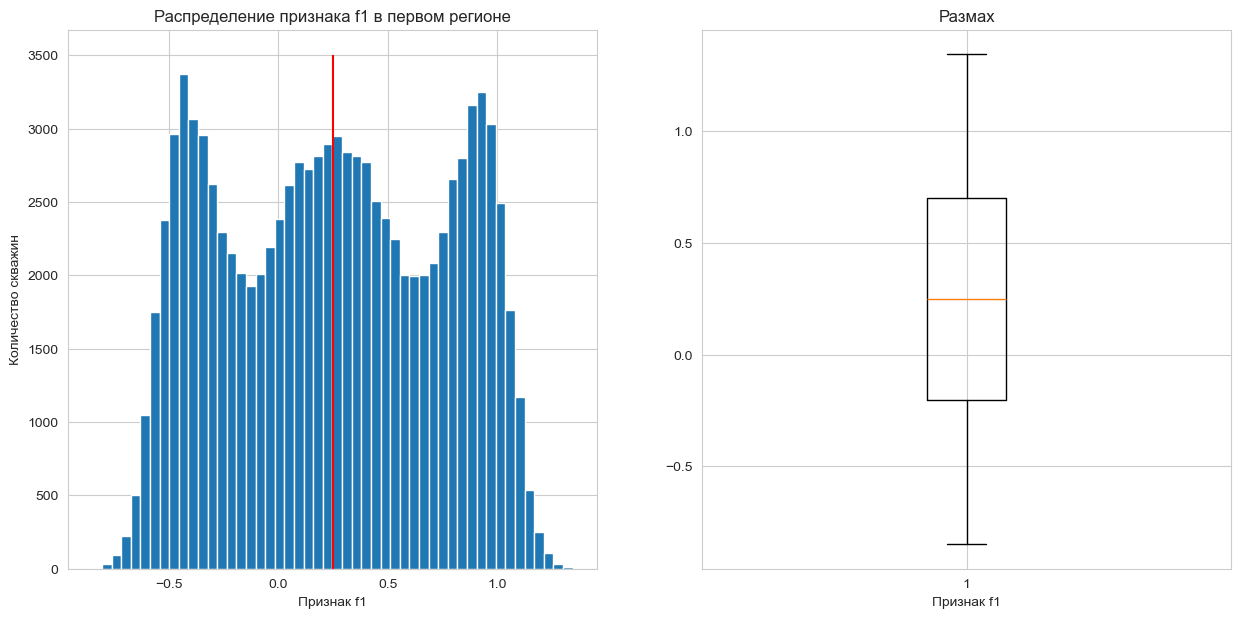

In [25]:
figure, ax =plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
ax[0].hist(geo_0['f1'], bins=50)
ax[0].vlines(geo_0['f1'].mean(), ymin=0, ymax=3500, color='red')
ax[0].set_title('Распределение признака f1 в первом регионе')
ax[0].set_xlabel('Признак f1')
ax[0].set_ylabel('Количество скважин')


ax[1].boxplot(geo_0['f1'])
ax[1].set_title('Размах')
ax[1].set_xlabel('Признак f1')
plt.show()

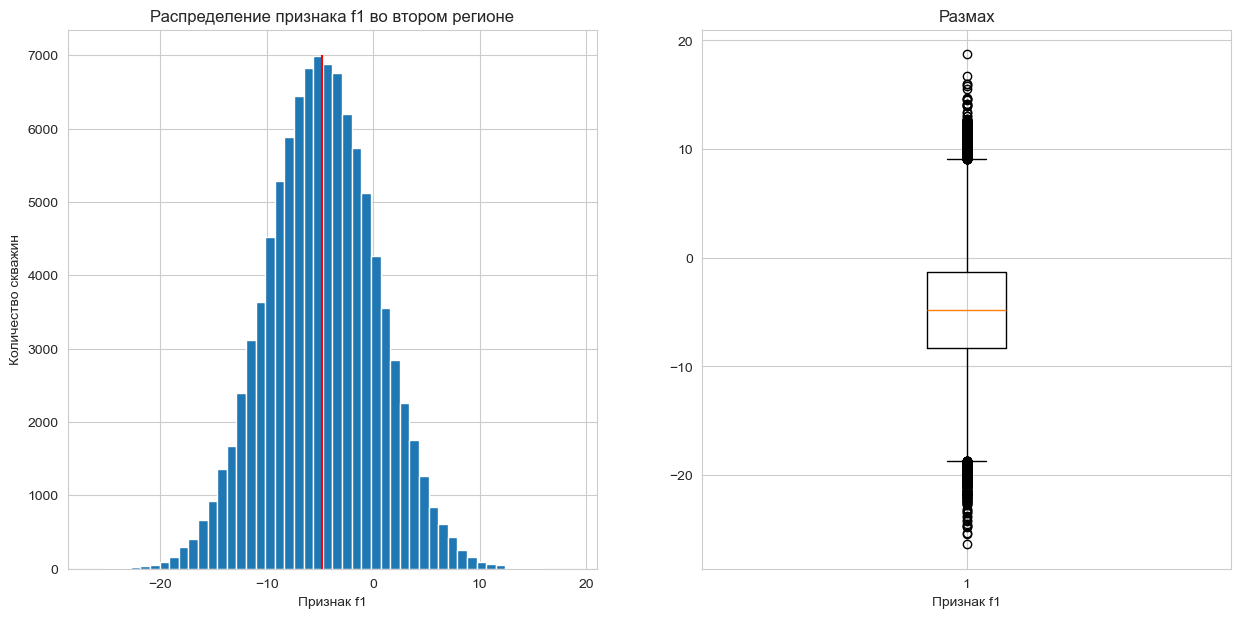

In [26]:
figure, ax =plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
ax[0].hist(geo_1['f1'], bins=50)
ax[0].vlines(geo_1['f1'].mean(), ymin=0, ymax=7000, color='red')
ax[0].set_title('Распределение признака f1 во втором регионе')
ax[0].set_xlabel('Признак f1')
ax[0].set_ylabel('Количество скважин')


ax[1].boxplot(geo_1['f1'])
ax[1].set_title('Размах')
ax[1].set_xlabel('Признак f1')
plt.show()

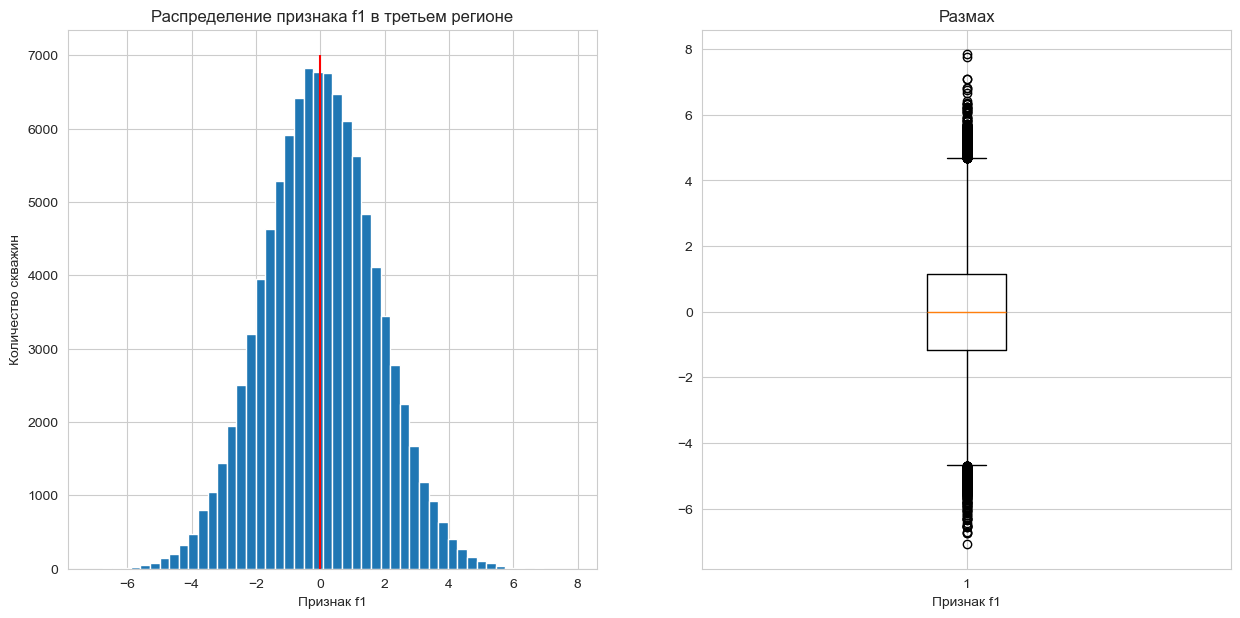

In [27]:
figure, ax =plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
ax[0].hist(geo_2['f1'], bins=50)
ax[0].vlines(geo_2['f1'].mean(), ymin=0, ymax=7000, color='red')
ax[0].set_title('Распределение признака f1 в третьем регионе')
ax[0].set_xlabel('Признак f1')
ax[0].set_ylabel('Количество скважин')


ax[1].boxplot(geo_2['f1'])
ax[1].set_title('Размах')
ax[1].set_xlabel('Признак f1')
plt.show()

#### Признак f2

In [28]:
display(geo_0.f2.describe())
display(geo_1.f2.describe())
geo_2.f2.describe()

count    99990.000000
mean         2.502629
std          3.248149
min        -12.088328
25%          0.287784
50%          2.515969
75%          4.715035
max         16.003790
Name: f2, dtype: float64

count    99996.000000
mean         2.494501
std          1.703579
min         -0.018144
25%          1.000021
50%          2.011475
75%          3.999904
max          5.019721
Name: f2, dtype: float64

count    99996.000000
mean         2.495084
std          3.473482
min        -11.970335
25%          0.130269
50%          2.484236
75%          4.858720
max         16.739402
Name: f2, dtype: float64

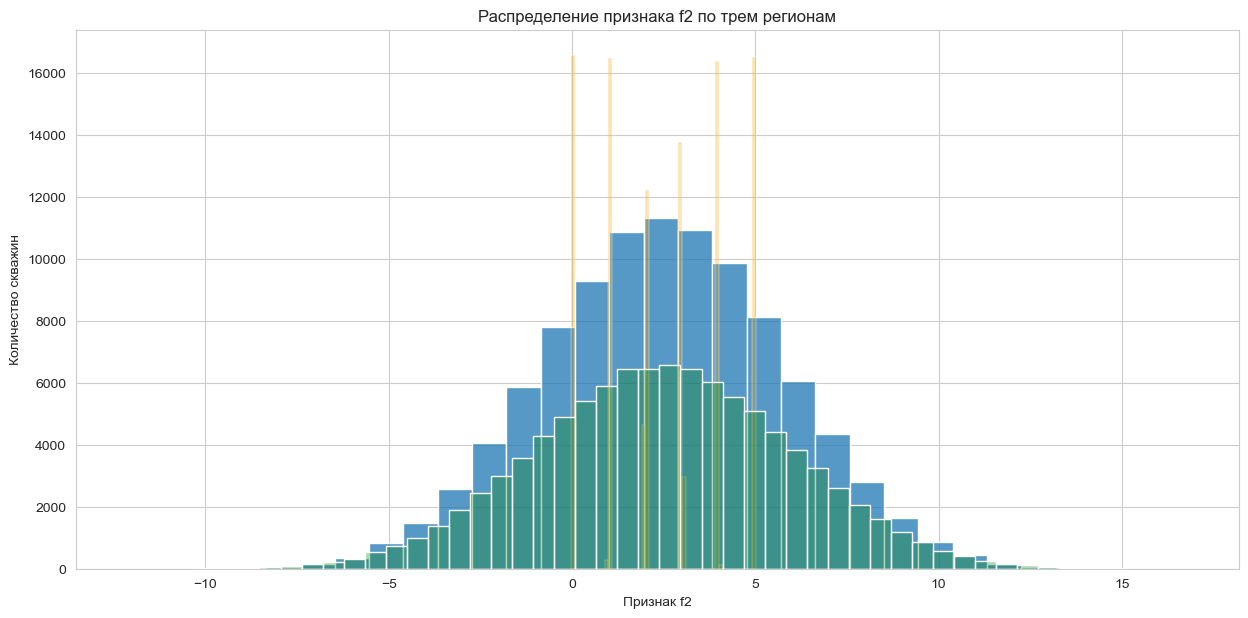

In [29]:
plt.figure(figsize=(15,7))
b = sns.histplot(data=geo_0, bins=30,  x ='f2')
sns.histplot(data=geo_1, bins=50, x = 'f2', color='orange', alpha=0.3)
sns.histplot(data=geo_2, bins=50, x = 'f2', color='green', alpha=0.3)
plt.title('Распределение признака f2 по трем регионам')
b.set_xlabel('Признак f2')
b.set_ylabel('Количество скважин');

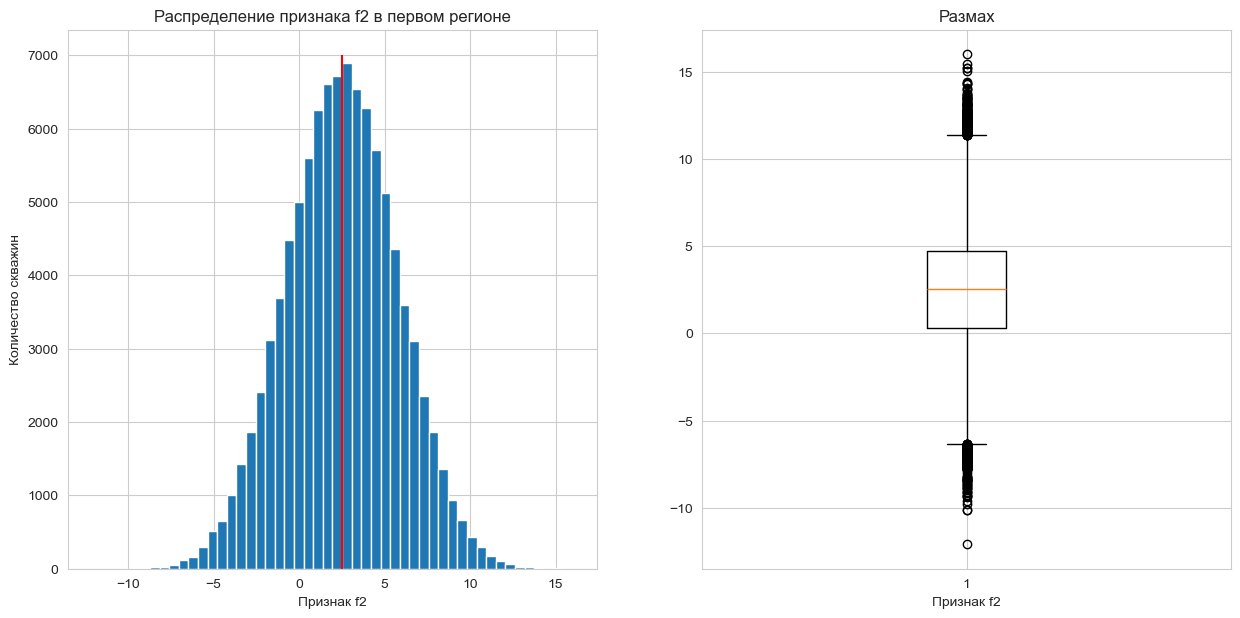

In [30]:
figure, ax =plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
ax[0].hist(geo_0['f2'], bins=50)
ax[0].vlines(geo_0['f2'].mean(), ymin=0, ymax=7000, color='red')
ax[0].set_title('Распределение признака f2 в первом регионе')
ax[0].set_xlabel('Признак f2')
ax[0].set_ylabel('Количество скважин')


ax[1].boxplot(geo_0['f2'])
ax[1].set_title('Размах')
ax[1].set_xlabel('Признак f2')
plt.show()

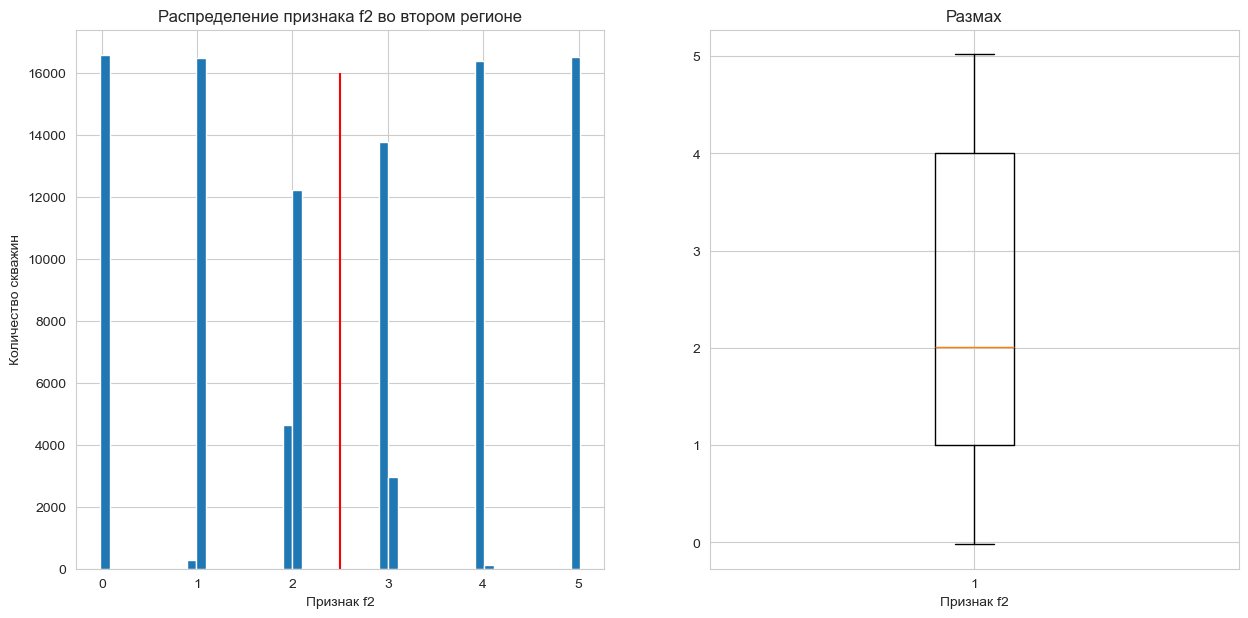

In [31]:
figure, ax =plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
ax[0].hist(geo_1['f2'], bins=50)
ax[0].vlines(geo_1['f2'].mean(), ymin=0, ymax=16000, color='red')
ax[0].set_title('Распределение признака f2 во втором регионе')
ax[0].set_xlabel('Признак f2')
ax[0].set_ylabel('Количество скважин')


ax[1].boxplot(geo_1['f2'])
ax[1].set_title('Размах')
ax[1].set_xlabel('Признак f2')
plt.show()

In [32]:
geo_1.query('1 < f2 < 2')

,id,f0,f1,f2,product
30,YVVPX,11.726927,-4.285120,1.003547,26.953261
34,5O3Zt,-4.792992,-7.569682,1.004281,30.132364
43,bBa22,-8.140922,-6.899974,1.004955,30.132364
54,86e7T,0.153587,-5.519640,1.000867,26.953261
56,56IYh,2.138594,-7.339354,1.997582,53.906522
...,...,...,...,...,...
99988,UNiyp,-9.795869,-12.867840,1.994554,57.085625
99990,6HSBo,4.280434,-1.692187,1.011469,26.953261
99991,obwpN,2.233158,-1.970310,1.004117,26.953261
99995,QywKC,9.535637,-6.878139,1.998296,53.906522


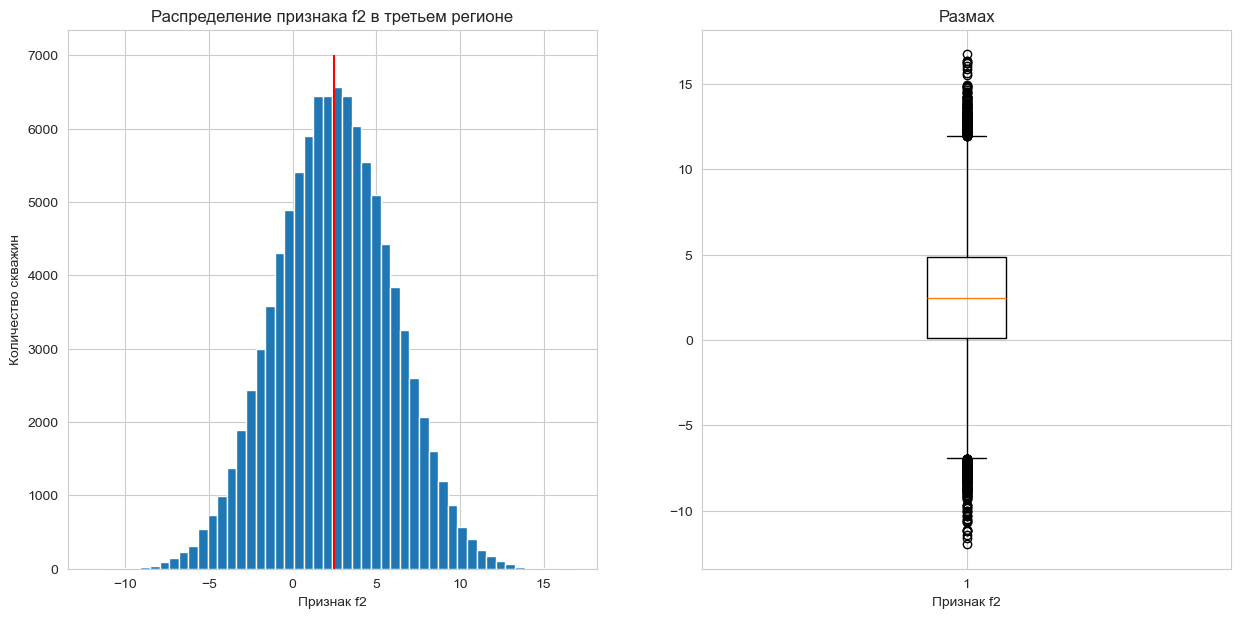

In [33]:
figure, ax =plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
ax[0].hist(geo_2['f2'], bins=50)
ax[0].vlines(geo_2['f2'].mean(), ymin=0, ymax=7000, color='red')
ax[0].set_title('Распределение признака f2 в третьем регионе')
ax[0].set_xlabel('Признак f2')
ax[0].set_ylabel('Количество скважин')


ax[1].boxplot(geo_2['f2'])
ax[1].set_title('Размах')
ax[1].set_xlabel('Признак f2')
plt.show()

**Вывод:**
- Поскольку данные синтетические, они распределены симметрично относительно среднего, это наблюдается во всех признаках, кроме f2 в датафрейме geo_1, где значения распределены около целых чисел от 0 до 5 и отклоняются от них на тысячные или сотые. 
- Большинство признаков распределены нормально, признак f0 в датасете geo_1 с бимодальным распределением, а в датасете geo_0 признаки f0 и f1 также мультимодальные с 4 и 3 пиками соответственно. 
- Следующие признаки смещены вправо относительно 0: 
    - в geo_0 f0, f1, f2
    - в geo_1 f0 незначительно 
    - в geo_2 f2
- Признак f1 в geo_1 смещен влево.
- Остальные признаки распределены симметрично относительно 0. 

Проведем корреляционный анализ, поскольку в некоторых данных есть выбросы проверим корреляцию при помощи коэффициента Спирмена. 

#### Корреляционный анализ 

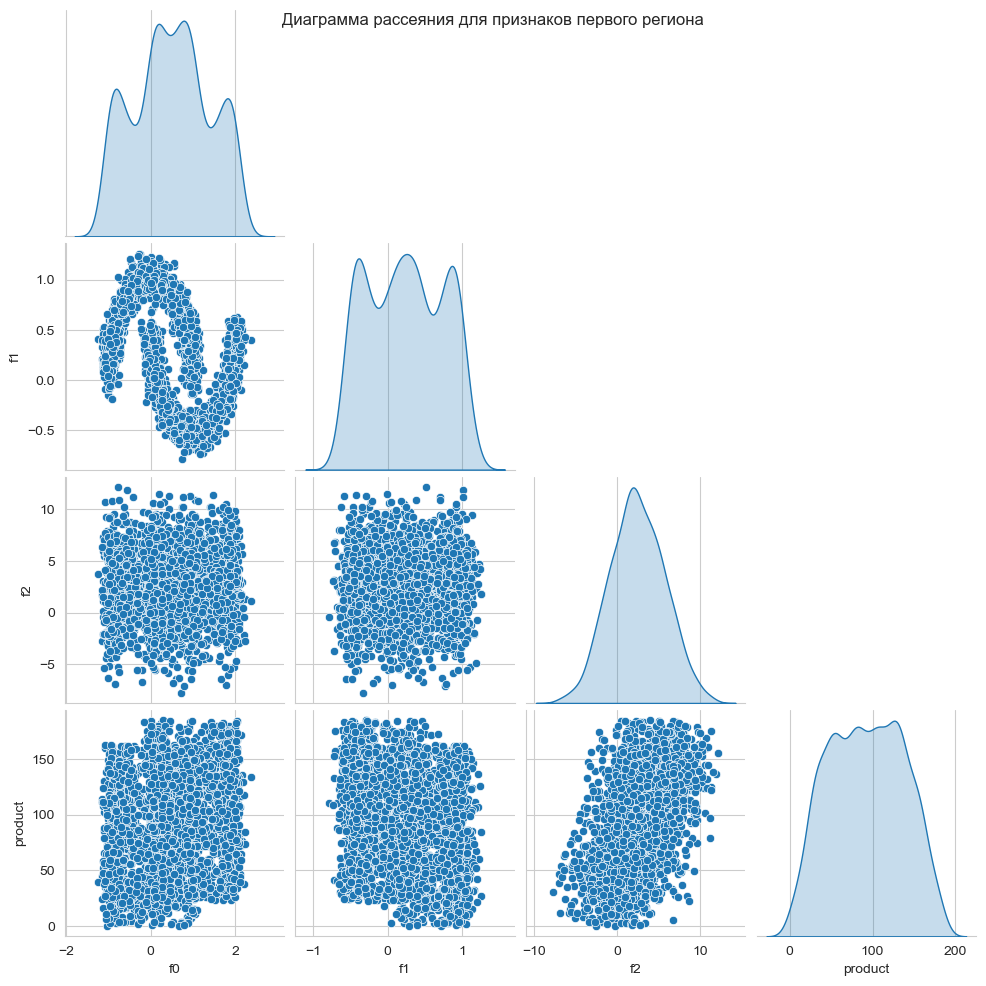

In [34]:
a = sns.pairplot(geo_0.drop('id', axis=1).sample(2500), corner=True, diag_kind="kde")
a.fig.suptitle('Диаграмма рассеяния для признаков первого региона');

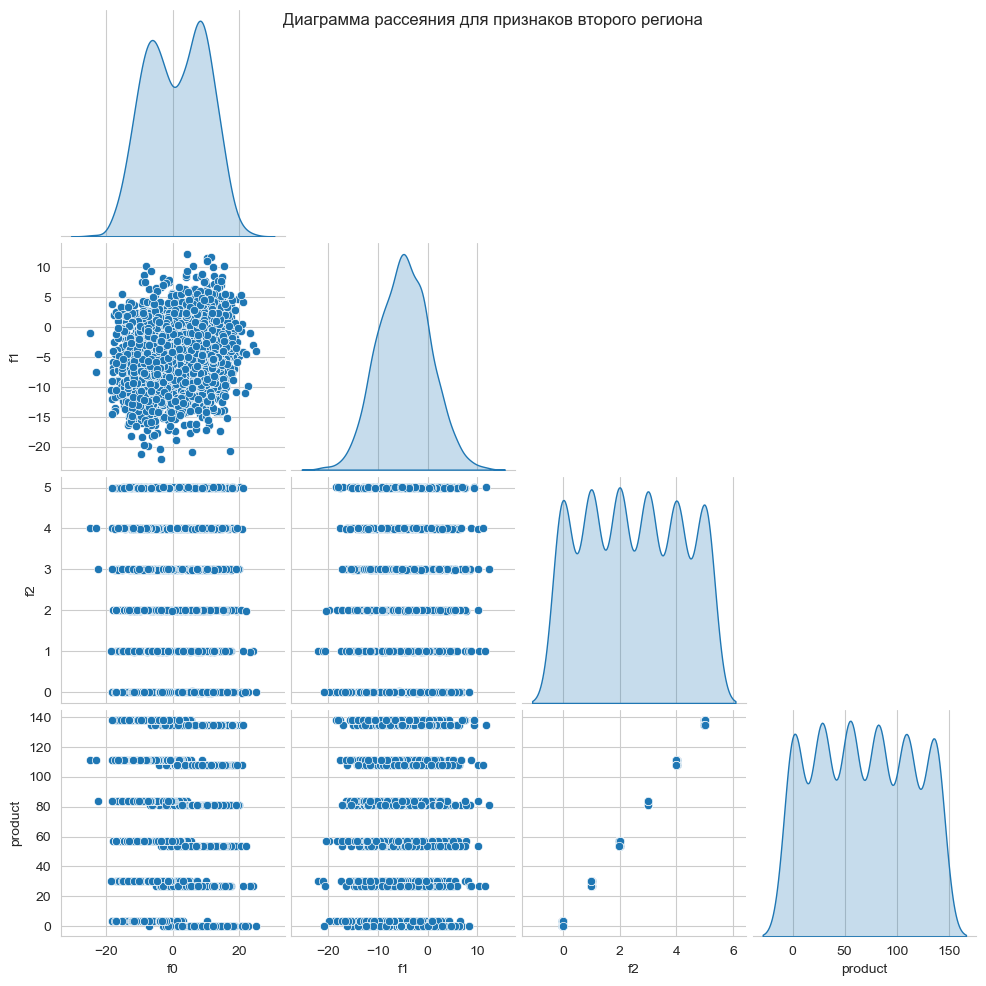

In [35]:
a = sns.pairplot(geo_1.drop('id', axis=1).sample(2500), corner=True, diag_kind="kde")
a.fig.suptitle('Диаграмма рассеяния для признаков второго региона');

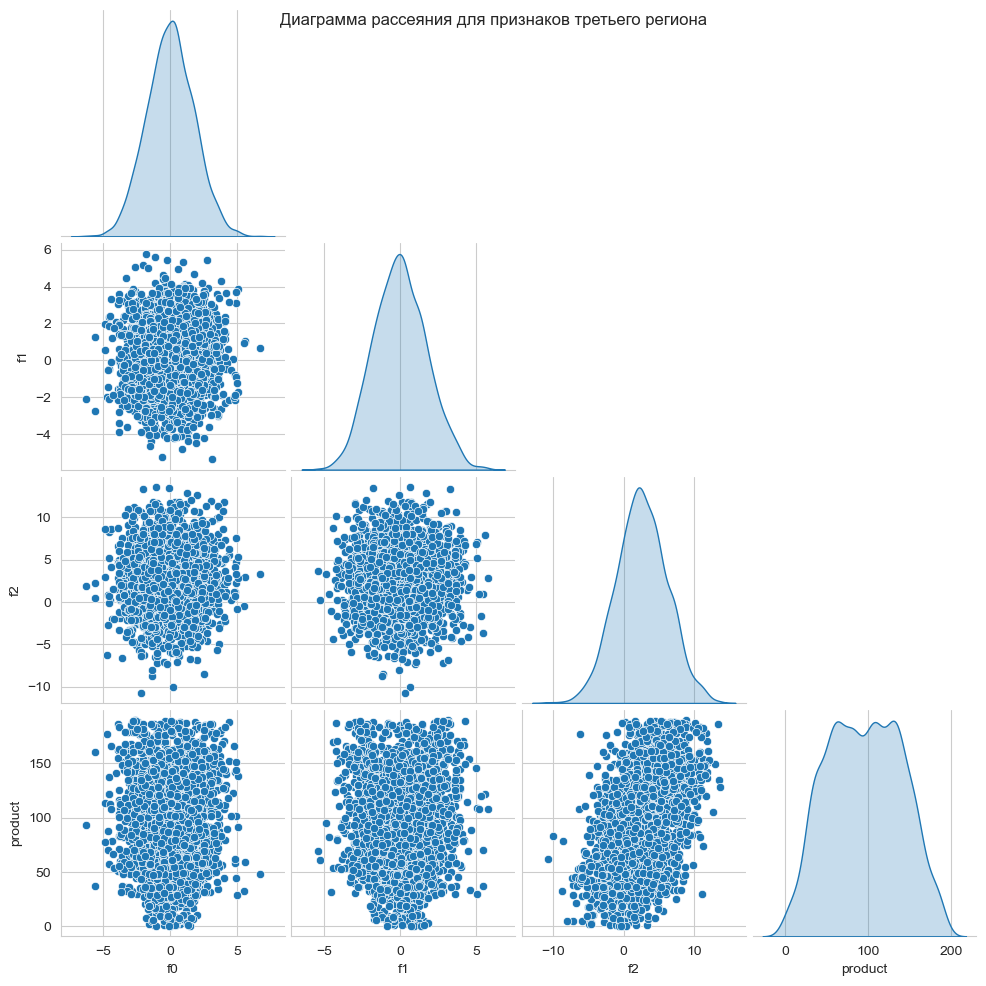

In [36]:
a = sns.pairplot(geo_2.drop('id', axis=1).sample(2500), corner=True, diag_kind="kde")
a.fig.suptitle('Диаграмма рассеяния для признаков третьего региона');

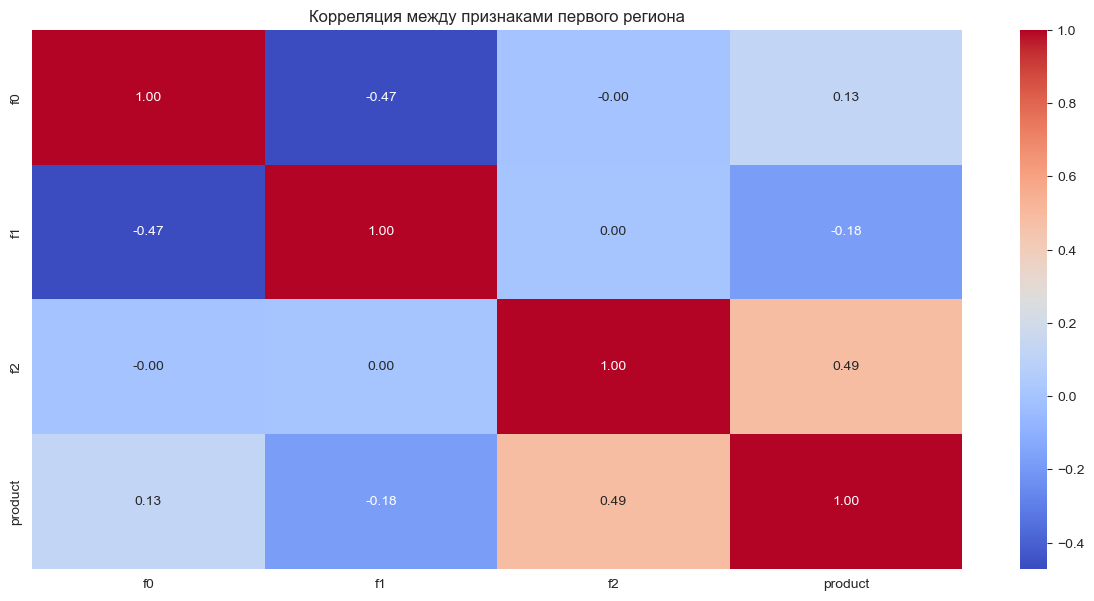

In [37]:
plt.figure(figsize=(15, 7))
sns.heatmap(geo_0.drop('id', axis=1).corr(method='spearman'), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Корреляция между признаками первого региона')
plt.show()

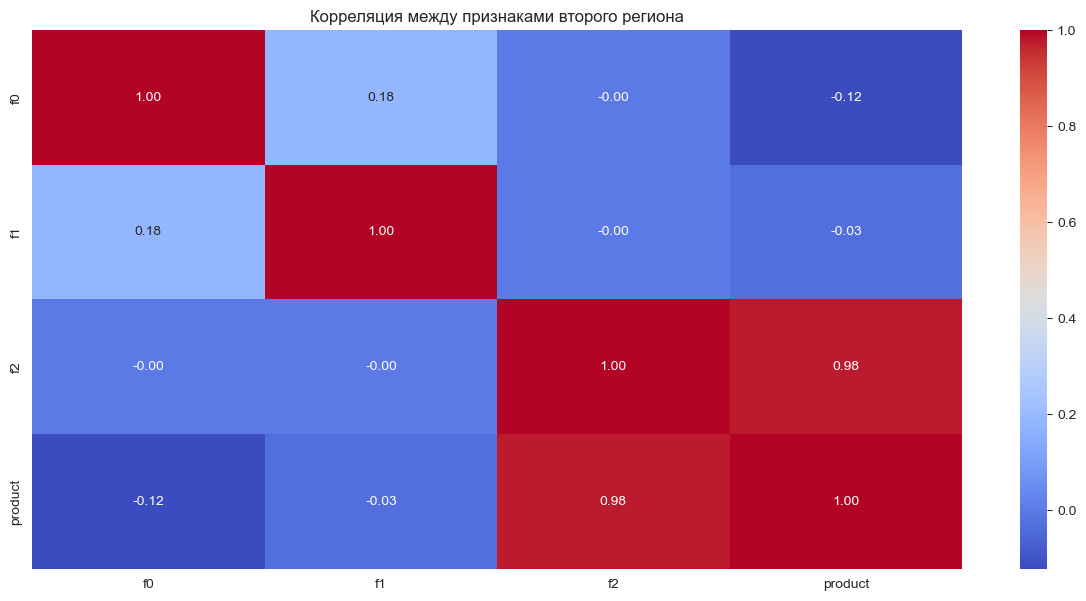

In [38]:
plt.figure(figsize=(15, 7))
sns.heatmap(geo_1.drop('id', axis=1).corr(method='spearman'), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Корреляция между признаками второго региона')
plt.show()

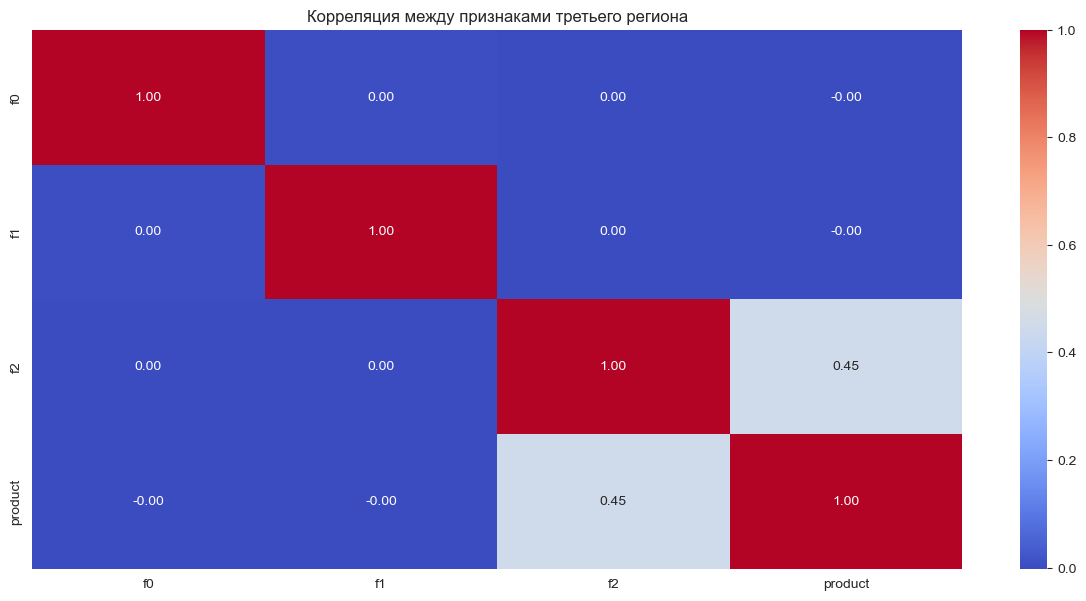

In [39]:
plt.figure(figsize=(15, 7))
sns.heatmap(geo_2.drop('id', axis=1).corr(method='spearman'), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Корреляция между признаками третьего региона')
plt.show()

C:\Users\79104\anaconda3\Lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable product is large: 99990. Are you sure this is not an interval variable? Analysis for pairs of variables including product can be slow.
  warnings.warn(


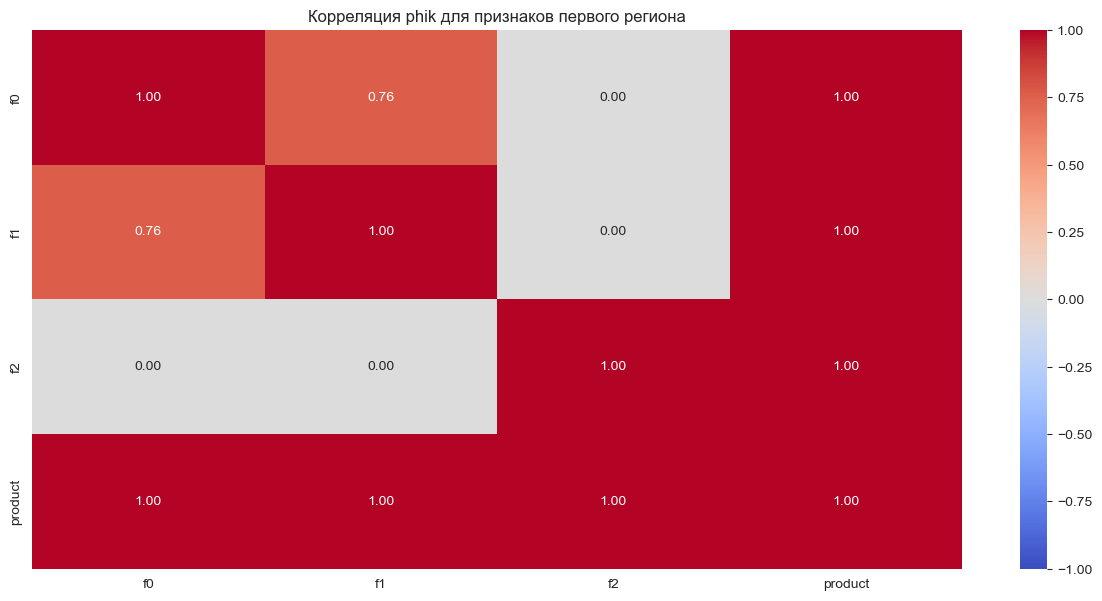

In [40]:
corr_phik_0 = geo_0.drop('id', axis=1).phik_matrix(interval_cols=['f0', 'f1', 'f2'])
plt.figure(figsize=(15, 7))
sns.heatmap(corr_phik_0, cmap='coolwarm', vmin=-1, annot=True, fmt='.2f')
plt.title('Корреляция phik для признаков первого региона')
plt.show()

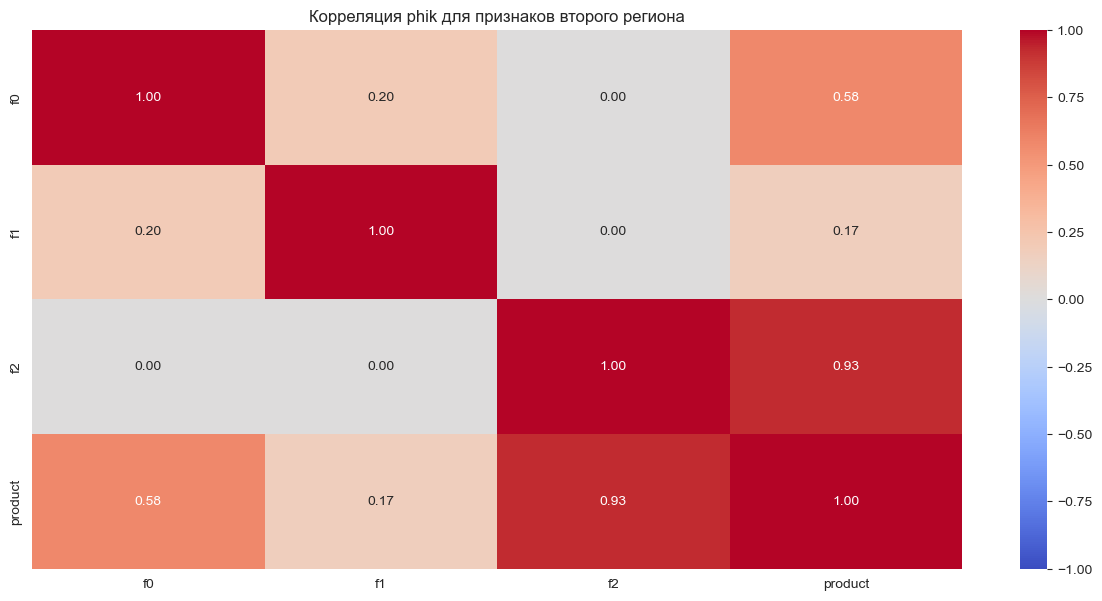

In [41]:
corr_phik_1 = geo_1.drop('id', axis=1).phik_matrix(interval_cols=['f0', 'f1', 'f2'])
plt.figure(figsize=(15, 7))
sns.heatmap(corr_phik_1, cmap='coolwarm', vmin=-1, annot=True, fmt='.2f')
plt.title('Корреляция phik для признаков второго региона')
plt.show()

C:\Users\79104\anaconda3\Lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable product is large: 99996. Are you sure this is not an interval variable? Analysis for pairs of variables including product can be slow.
  warnings.warn(


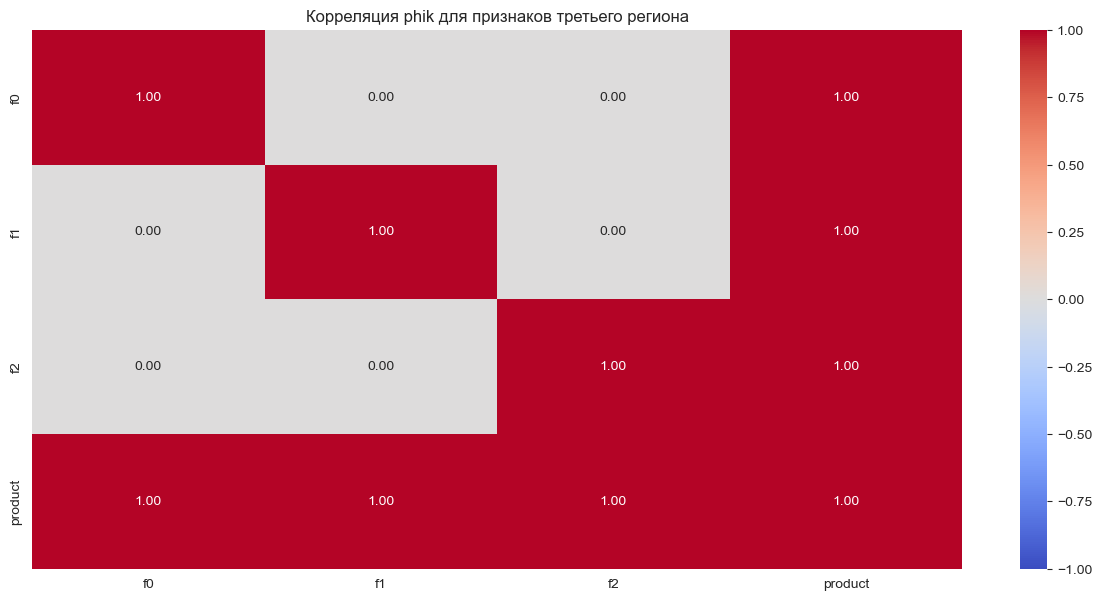

In [42]:
corr_phik_2 = geo_2.drop('id', axis=1).phik_matrix(interval_cols=['f0', 'f1', 'f2'])
plt.figure(figsize=(15, 7))
sns.heatmap(corr_phik_2, cmap='coolwarm', vmin=-1, annot=True, fmt='.2f')
plt.title('Корреляция phik для признаков третьего региона')
plt.show()

**Вывод:**
- Наиболее ярко выраженная линейная связь с целевым у признака f2 во втором регионе, скорее всего, именно на этом наборе данных линейная регрессия выявит наиболее точную зависимость и предсказания будут наиболее достоверными, в других датасетах сущестует средняя линейная связь между целевым признаком и также признаком f2.
- Основываясь на диаграмме рассеяния мы увидели вероятность существования нелинейной связи между признаками, что подтверждается матрицами корреляции phik, которые отражают также и наличие нелинейной зависимости. В третьем и первом регионе данная зависимость 100%, в связи с чем, вероятно, в ТЗ указано использовать только модель линейной регрессии. 
- Вероятнее всего, показатели модели будут приемлемыми только на втором наборе данных. 

## Обучение и проверка модели

In [43]:
# разбиваем данные на обучающую и валидационную выборки
RANDOM_STATE=55
TEST_SIZE=0.25

X_0 = geo_0.drop(['id', 'product'], axis=1)
y_0 = geo_0['product']
X_1 = geo_1.drop(['id', 'product'], axis=1)
y_1 = geo_1['product']
X_2 = geo_2.drop(['id', 'product'], axis=1)
y_2 = geo_2['product']

X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X_0, y_0, random_state=RANDOM_STATE, test_size=TEST_SIZE)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, random_state=RANDOM_STATE, test_size=TEST_SIZE)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, random_state=RANDOM_STATE, test_size=TEST_SIZE)

In [44]:
#подготовка данных - масштабирование числовых данных

scaler0 = RobustScaler()
X_train_0 = scaler0.fit_transform(X_train_0)
X_test_0 = scaler0.transform(X_test_0)

scaler1 = RobustScaler()
X_train_1 = scaler1.fit_transform(X_train_1)
X_test_1 = scaler1.transform(X_test_1)

scaler2 = RobustScaler()
X_train_2 = scaler2.fit_transform(X_train_2)
X_test_2 = scaler2.transform(X_test_2)

In [45]:
def model(X_train, y_train, X_test, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'R² модели равен {round(r2, 2)}')
    print(f'RMSE модели равен {round(rmse, 2)}')
    return y_pred

In [46]:
#модель для первого региона
y_pred_0 = model(X_train_0, y_train_0, X_test_0, y_test_0)
print(f'Средний запас предсказанного сырья первого региона равен: {y_pred_0.mean()}')

R² модели равен 0.28
RMSE модели равен 37.6
Средний запас предсказанного сырья первого региона равен: 92.37948085761111


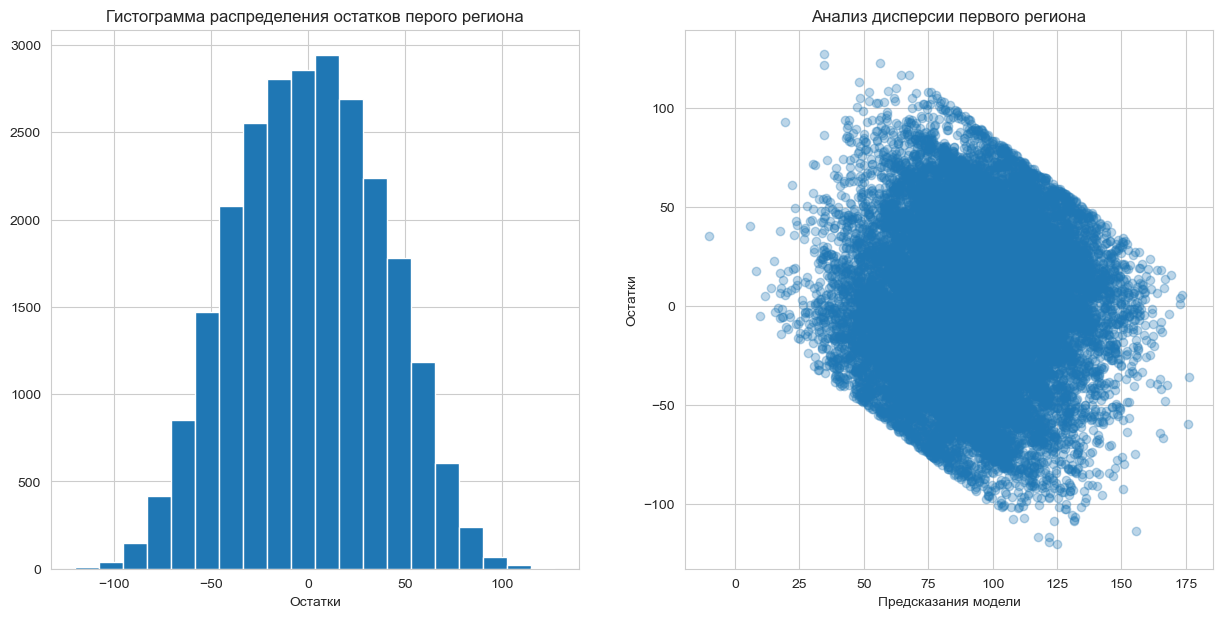

In [47]:
residuals_0 = y_test_0 - y_pred_0

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
axes[0].hist(residuals_0, bins=20)
axes[0].set_title('Гистограмма распределения остатков перого региона')
axes[0].set_xlabel('Остатки')

axes[1].scatter(y_pred_0, residuals_0, alpha=0.3)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии первого региона')
plt.show()

In [48]:
#модель для второго региона
y_pred_1 = model(X_train_1, y_train_1, X_test_1, y_test_1)
print(f'Средний запас предсказанного сырья второго региона равен: {y_pred_1.mean()}')

R² модели равен 1.0
RMSE модели равен 0.89
Средний запас предсказанного сырья второго региона равен: 68.49878315013703


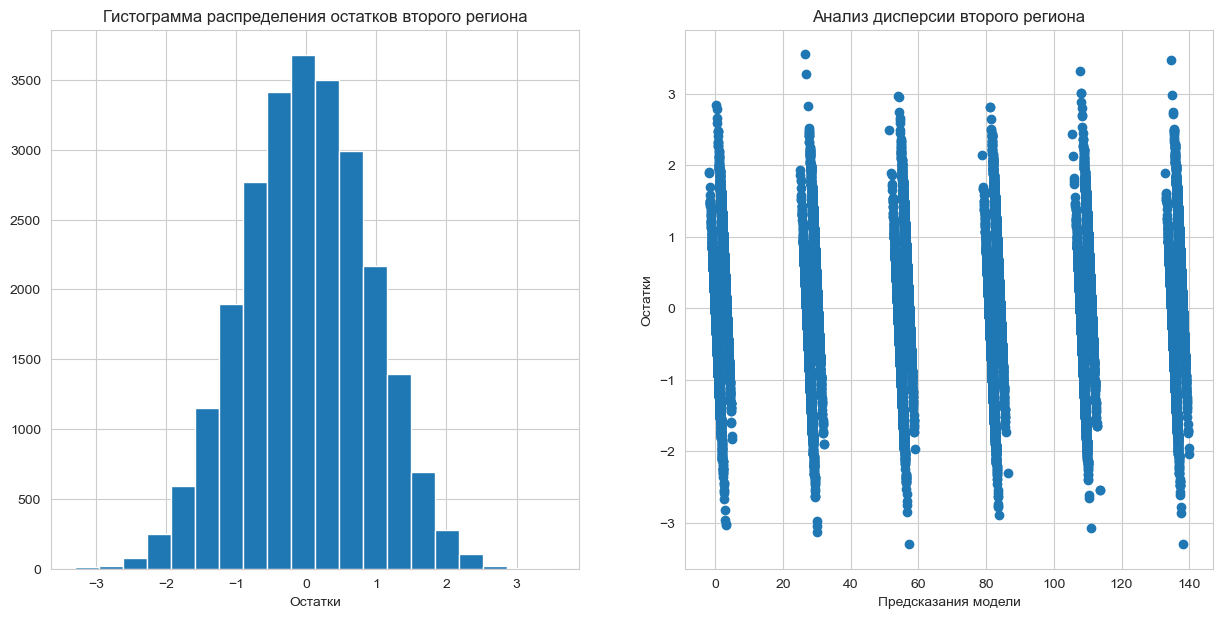

In [49]:
residuals_1 = y_test_1 - y_pred_1

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
axes[0].hist(residuals_1, bins=20)
axes[0].set_title('Гистограмма распределения остатков второго региона')
axes[0].set_xlabel('Остатки')

axes[1].scatter(y_pred_1, residuals_1)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии второго региона')
plt.show()

In [50]:
#модель для третьего региона
y_pred_2 = model(X_train_2, y_train_2, X_test_2, y_test_2)
print(f'Средний запас предсказанного сырья третьего региона равен: {y_pred_2.mean()}')

R² модели равен 0.2
RMSE модели равен 40.0
Средний запас предсказанного сырья третьего региона равен: 95.10514622716796


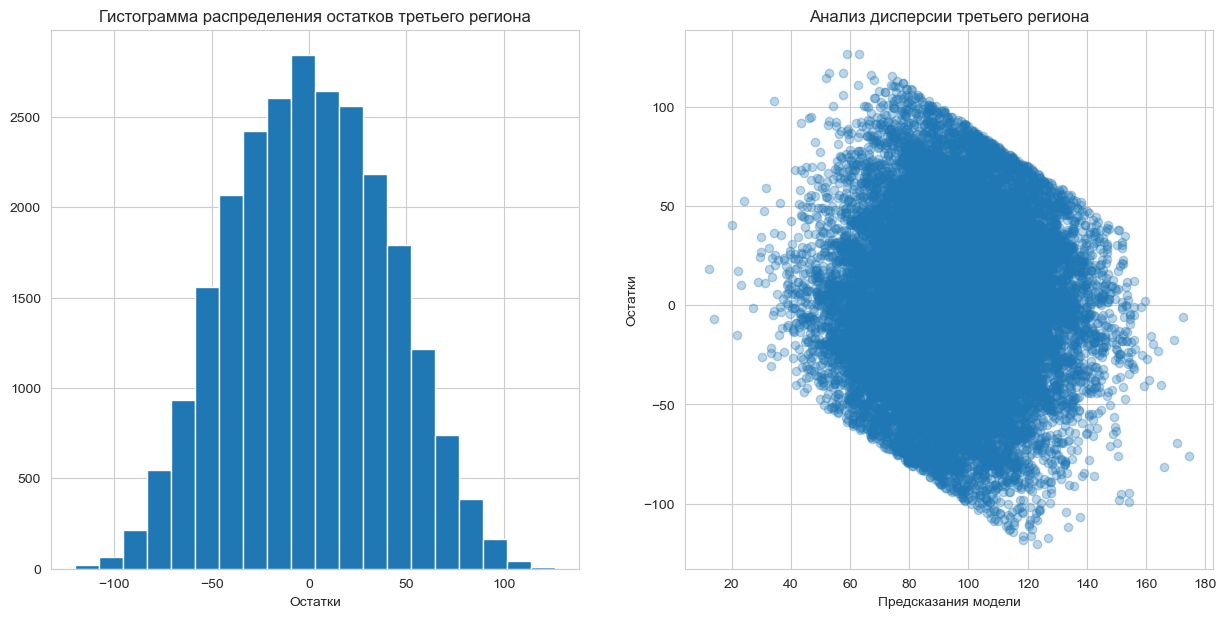

In [51]:
residuals_2 = y_test_2 - y_pred_2

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
axes[0].hist(residuals_2, bins=20)
axes[0].set_title('Гистограмма распределения остатков третьего региона')
axes[0].set_xlabel('Остатки')

axes[1].scatter(y_pred_2, residuals_2, alpha=0.3)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии третьего региона')
plt.show()

**Вывод**
- Коэффициент детерминации указывает на точную работу модели для второго региона, качество других двух моделей значительно ниже, что говорит о том, что модель плохо понимает закономерности и структуру данных, которые объясняют изменения в целевом признаке. Идеальный показатель модели может объясняться простым набором данных, специально подобранных под данное задание для получения высокого показателя. 
- При этом метрика RMSE лучше в двух других регионах, поскольку она ближе к 0. Она показывает, насколько в среднем прогнозы отличаются от фактических значений. Более высокое значение во второй модели данного показателя может объясняться распределением данных целевого признака в датасете geo_1 по 12 уникальным значениям. При этом показатель метрики довольно близко к 0, что при коэффициенте детерминации равном 1 дает отличный результат. 
- Остатки первой и третьей модели структурированно распределены и имеют форму ромба, что указывает на наличие неслучайных закономерностей, которые модель не учитывает. Остатки несимметрично распределены вокруг 0. Таким образом, дисперсия помогает понять, что необходимы модель с более сложной зависимостью, чем линейная, для первого и третьего набора данных.
- Остатки второй модели сгруппированы в дискретные вертикальные полосы при определенных значениях, что означает, что предсказываемые данные не непрерывные, что соответствует изначальным 12 уникальным значениям целевого признака. При этом дисперсия постоянна, а остатки симметричны относительно 0. Отсутствие кривизны или рисунка указывают на то, что линейная регрессия является подходящей моделью для данного набора данных. 
- Средние значения запаса предсказанного сырья во всех трех регионах в незначительной степени (на 1000 или меньше баррелей) отличается от истинного среднего значения запасов по регионам.

## Подготовка к расчёту прибыли

- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

In [52]:
#переменные для расчетов
def series_maker(array):
    a = pd.Series(array)
    return a

In [53]:
y_pred_0 = series_maker(y_pred_0) #сохраним в формате series предсказания и истинные значения по 3 регионам
y_pred_1 = series_maker(y_pred_1)
y_pred_2 = series_maker(y_pred_2)
y_test_0 = series_maker(y_test_0)
y_test_1 = series_maker(y_test_1)
y_test_2 = series_maker(y_test_2)

budget = 10000000000 #бюджет для 1 региона
income = 450000 #доход от 1000 баррелей (1 единицы)
losses = 0.025 #порог вероятности убытков
units = 200 #количество скважин для разработки
budget_per_un = budget/units #бюджет на 1 скважину

In [54]:
print(f'Чтобы разработка скважины окупилась, необходимо чтобы каждая из них приносила {budget_per_un} рублей')
needed_barrels = budget_per_un / income
print(f'Чтобы получить минимальную сумму с одной скажины, нужно чтобы она давала {needed_barrels} тысяч баррелей')

Чтобы разработка скважины окупилась, необходимо чтобы каждая из них приносила 50000000.0 рублей
Чтобы получить минимальную сумму с одной скажины, нужно чтобы она давала 111.11111111111111 тысяч баррелей


In [55]:
# расчитаем прибыль от региона 
# сырье по 200 скважинам * стоимость 1 ед сырья - бюджет региона
def profit(y_true, y_pred, budget, income, units):
    y_pred.index = y_true.index
    y_pred_sort = y_pred.sort_values(ascending=False) #располагаем скважины с наибольшим числом баррелей в начале
    product = y_true[y_pred_sort.index][:units] #выбираем самые доходные по предсказаниям скважины 
    all_income = np.sum(product * income) #доход со всех разрабатываемых скважин
    profit = all_income - budget
    return profit

- При разработке 200 скважин в каждом регионе, чтобы покрыть расходы необходимо с каждой скважины получать 50 млн рублей. 
- Так как 1 добываемая единица приносит 450 тысяч рублей, то минимально необходимо добыть 111.12 тысяч баррелей. 
- Как мы помним из прдыдущих расчетов, среднее значение запаса сырья в первом и третьем районе до 95 тысяч баррелей, а среднее значение во втором регионе - 70 тысяч баррелей. То есть необходимо добывать сырья больше среднего значения по региону.
- Написана функция по расчету прибыли в регионе

## Расчёт прибыли и рисков 

In [56]:
profit_0 = profit(y_test_0, y_pred_0, budget, income, units)
profit_1 = profit(y_test_1, y_pred_1, budget, income, units)
profit_2 = profit(y_test_2, y_pred_2, budget, income, units)

print(f'Прибыль с первого региона равна {round(profit_0, 2)} руб')
print(f'Прибыль со второго региона равна {round(profit_1, 2)} руб')
print(f'Прибыль с третьего региона равна {round(profit_2, 2)} руб')

Прибыль с первого региона равна 3357191819.37 руб
Прибыль со второго региона равна 2415086696.68 руб
Прибыль с третьего региона равна 2507801656.0 руб


In [57]:
def bootsrap(y_true, y_pred):
    state = np.random.RandomState(12345)
    values = []
    
    for i in range(1000):
        y_pred.index = y_true.index
        y_true_subsamples = y_true.sample(n=500, replace=True, random_state=state)
        y_pred_subsamples = y_pred[y_true_subsamples.index]
        
        y_true_subsamples = y_true_subsamples.reset_index(drop=True)
        y_pred_subsamples = y_pred_subsamples.reset_index(drop=True)
        
        values.append(profit(y_true_subsamples, y_pred_subsamples, budget, income, units))
        
    values= pd.Series(values)
    return values

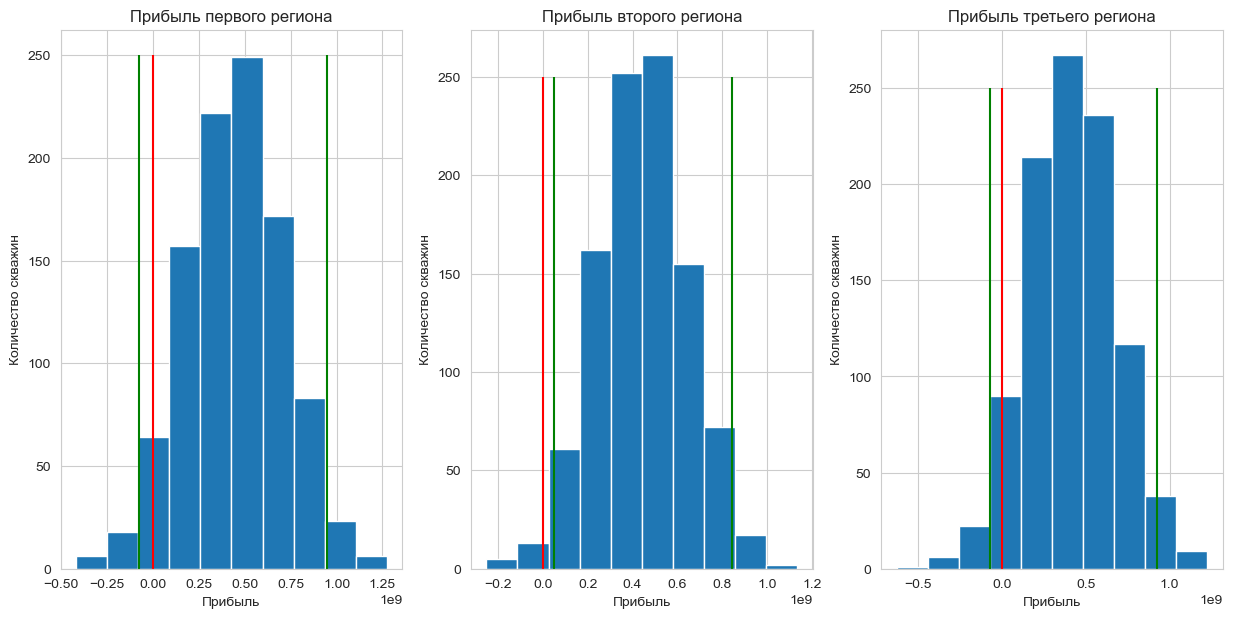

In [58]:
profit_subsamples_0 = bootsrap(y_test_0, y_pred_0)
profit_subsamples_1 = bootsrap(y_test_1, y_pred_1)
profit_subsamples_2 = bootsrap(y_test_2, y_pred_2)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 7))
axes[0].hist(profit_subsamples_0)
axes[0].set_title('Прибыль первого региона')
axes[0].vlines(0, ymin=0, ymax=250, color='red')
axes[0].vlines(profit_subsamples_0.quantile(0.025), ymin=0, ymax=250, color='green')
axes[0].vlines(profit_subsamples_0.quantile(0.975), ymin=0, ymax=250, color='green')
axes[0].set_xlabel('Прибыль')
axes[0].set_ylabel('Количество скважин')

axes[1].hist(profit_subsamples_1)
axes[1].set_title('Прибыль второго региона')
axes[1].vlines(0, ymin=0, ymax=250, color='red')
axes[1].vlines(profit_subsamples_1.quantile(0.025), ymin=0, ymax=250, color='green')
axes[1].vlines(profit_subsamples_1.quantile(0.975), ymin=0, ymax=250, color='green')
axes[1].set_xlabel('Прибыль')
axes[1].set_ylabel('Количество скважин')

axes[2].hist(profit_subsamples_2)
axes[2].set_title('Прибыль третьего региона')
axes[2].vlines(0, ymin=0, ymax=250, color='red')
axes[2].vlines(profit_subsamples_2.quantile(0.025), ymin=0, ymax=250, color='green')
axes[2].vlines(profit_subsamples_2.quantile(0.975), ymin=0, ymax=250, color='green')
axes[2].set_xlabel('Прибыль')
axes[2].set_ylabel('Количество скважин')
plt.show()

In [59]:
#создадим функцию для расчета риска убытков, средней прибыли и доверительного интервала
def region_info(profit_subsamples):
    risk = profit_subsamples[profit_subsamples < 0].count() / 1000
    lower=profit_subsamples.quantile(0.025)
    upper=profit_subsamples.quantile(0.975)
    print(f'Средняя прибыль в регионе равна {round(profit_subsamples.mean(), 2)} рублей')
    print(f'Доверительный интервал 95% равен {round(lower, 2)}-{round(upper, 2)}')
    print(f'Риск убытков равен {risk *100}%')

In [60]:
#первый регион
region_info(profit_subsamples_0)

Средняя прибыль в регионе равна 448336451.99 рублей
Доверительный интервал 95% равен -74309024.46-946233445.75
Риск убытков равен 5.3%


In [61]:
#второй регион
region_info(profit_subsamples_1)

Средняя прибыль в регионе равна 445065280.24 рублей
Доверительный интервал 95% равен 48143575.98-844416509.99
Риск убытков равен 1.4000000000000001%


In [62]:
#третий регион
region_info(profit_subsamples_2)

Средняя прибыль в регионе равна 414576872.76 рублей
Доверительный интервал 95% равен -73638927.23-925489883.35
Риск убытков равен 5.3%


Среди трех регионо только у одного риск убытков меньше 2.5% - у второго региона. Остальные два региона не подходят для разработки в связи с высоким риском убыточности. Средний ожидаемый доход со второго региона - 445 миллионов рублей. В доверительном интервале нет убыточных значений. Визуализируем предсказания модели в сравнении с истинными значениями и доверительный интервал.

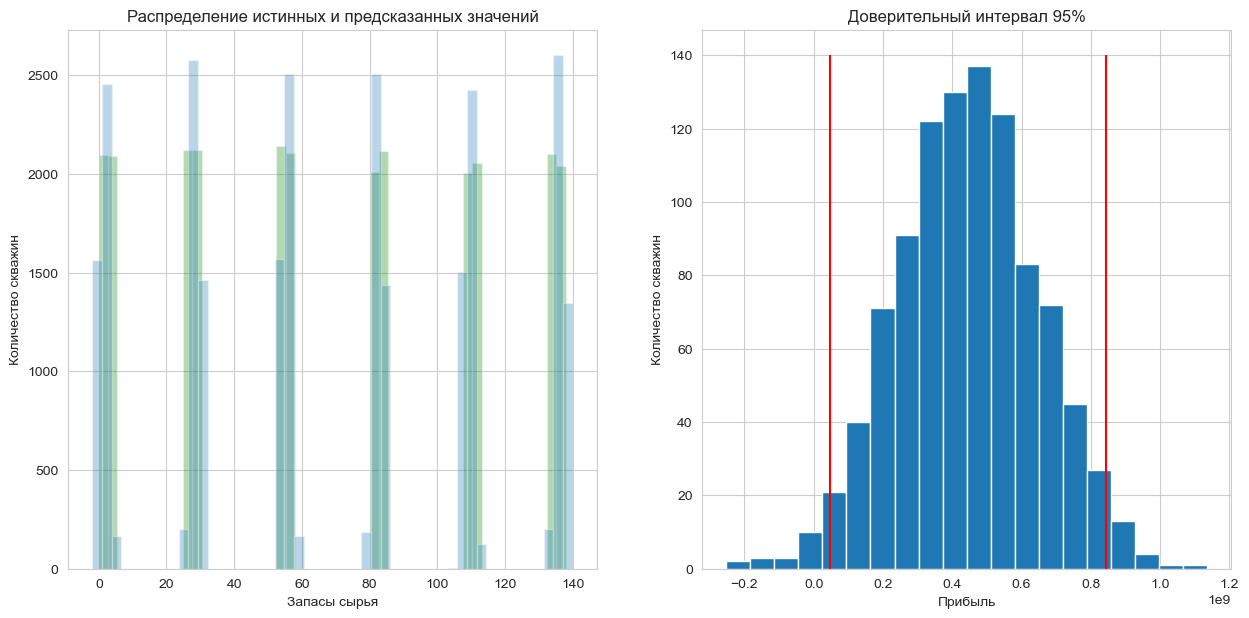

In [63]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
axes[0].hist(y_test_1, bins=50, color='green', alpha=0.3)
axes[0].hist(y_pred_1, bins=50, alpha=0.3)
axes[0].set_title('Распределение истинных и предсказанных значений')
axes[0].set_xlabel('Запасы сырья')
axes[0].set_ylabel('Количество скважин')

axes[1].hist(profit_subsamples_1, bins=20)
axes[1].set_title('Доверительный интервал 95%')
axes[1].vlines(profit_subsamples_1.quantile(0.025), ymin=0, ymax=140, color='red')
axes[1].vlines(profit_subsamples_1.quantile(0.975), ymin=0, ymax=140, color='red')
axes[1].set_xlabel('Прибыль')
axes[1].set_ylabel('Количество скважин')
plt.show()

## Итоговый вывод 

**Задача:**

Для добывающей компании «ГлавРосГосНефть» построить модель линейной регрессии, которая бы определила регион разработки скважин для добычи сырья с наибольшей прибылью и наименьшим риском убытков при использовании техники Bootstrap. 

**Предобработка данных**
- Среди датасетов по трем регионам добычи сырья были найдены неявные дубликаты - совпадающие id, которым соответствовала разная информация о скважине, в связи с неоднозначностью эти дубликаты были удалены. Пропусков и явных дубликатов не было, тип данных и названия столбцов не требовали изменений.
- Необычным показателем выделяется количество уникальных значений в целевом признаке второго региона - в запасах сырья. Предположительно, данный признак должен быть непрерывным, однако, 12 значений указывает на его категориальную сущность. 

**Исследовательский анализ и построение модели**
- Условием проведения данного исследования было обучение данных на линейной модели, тем не менее, для данных первого и третьего региона подходят в большей степени нелинейные модели, так как у них существует ярко выраженная нелинейная корреляция между входящими и целевым признаками, о чем свидетельствует матрица корреляции phik.
- Сильная линейная корреляция существует между признаком `f2` и целевым признаком в наборе данных для второго региона. Выделена средняя корреляция между признаком `f2` и целевым признаком в данных первого и третьего региона.
- В основном признаки распределены нормально, признаки `f0` в `geo_0`, `f0` в `geo_1` и `f1` в `geo_0` распределены мультимодально, также заметно отличаются значения признака `f2` в `geo_1`, то есть в признаке, который в большей степени коррелирует с целевым. Значения хотя и непрерывные, близки к целым значениям от 0 до 5 и отличаются от них лишь на тысячные.
- Наилучшее качество модели по коэффициенту детерминации r2 ожидаемо показала линейная модель для второго региона. Для остальных двух регионов качество низкое, поскольку в тех данных превалируют нелинейные связи, для улучшения качества предсказания необходимо выбрать другой вид моделей для поиска более сложных закономерностей.
- Метрика RMSE, указывающая на отклонение от фактических результатов у всех наборов данных хорошая, поскольку близка к 0. 

- Была создана функция для рассчета прибыли и рисков убытков на выборках, на основе результатов которых будут сделаны рекомендации ниже:

**Рекомендации**
- Наиболее надежным для добычи сырья регионом является второй, вероятность получения убытков равна приблизитльно 1,4%. Средняя прибыль равна примерно 445 млн рублей, а в доверительном интерваел 95% нет убыточных значений. Второй регион в большй степени подходи для дальнейшей добычи сырья.
- Можно попробовать рассмотрть возожность применения нелинйных моделей для улучшения предсказаний по данным первого и третьего региона. 